# Prepare Environment

In [ ]:
# Install required libraries
!pip install -U kaleido # for saving graphs
!pip install --upgrade plotly>=6.1.1 # make it compatible with kaleido

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
import os
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

In [3]:
# @title Filling missing values

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df

In [4]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [5]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [6]:
# @title Defining evaluation matrics forecast_metrics
def forecast_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

In [7]:
# Path to saved results
results_path = '/content/drive/MyDrive/BKW/Models/test_results_HH_LSTM_model_2.csv'

if os.path.exists(results_path):
    HH_results_df = pd.read_csv(results_path)
else:
    HH_results_df = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date', 'features'])

In [8]:
# @title Defining an model evalutation function
def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, features=None, results_df=None, save_path=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<30} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Check for existing entry to avoid duplicates
    if results_df is not None:
        exists = ((results_df['Label'] == label) & (results_df['cutoff_date'] == str(cutoff_date))).any()
        if not exists:
            features_str = ', '.join(features) if isinstance(features, list) else str(features)
            results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]
            if save_path:
                results_df.to_csv(save_path, index=False)

    return results_df

In [9]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'HH_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['HH_Price'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='HenryHub_Price ($/MMBtu)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [11]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")


In [12]:
#@title Function to Load Model and Training History
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and its training history.

    Parameters:
    - save_dir: directory path
    - model_name: base name used when saving

    Returns:
    - model: loaded Keras model
    - history: training history (as a dict)
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)

    # Load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    print(f"✅ Model loaded from: {model_path}")
    print(f"✅ History loaded from: {history_path}")
    return model, history


In [13]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

# Load data and EDA

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Price_inv_stor_LNG_water_pipe_TTFMc_raw_FIXED.xlsx'

In [15]:
# Load and prepare data
df_all = pd.read_excel(data_path + file_path)
df_all.head()

,Date,PSV_Price,Brent_Price,TTF_Futures_Price,PVB_Price,JKM_Price,NBP_Price,CBOE_Price,Coal_Price,HH_Price,...,TTFMc4_Ask,TTFMc5_Close,TTFMc6_Close,TTFMc6_OI,TTFMc7_Close,TTFMc7_OI,TTFMc8_Close,TTFMc8_OI,TTFMc9_Close,TTFMc9_OI
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,NaN,46.91,NaN,NaN,NaN,NaN,39.19,74.35,5.41,...,17.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,NaN,49.62,NaN,NaN,NaN,NaN,39.08,77.65,5.83,...,17.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Columns to plot
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['Brent_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'NBP_Price', 'PSV_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))

## Henry Hub Price Peaks and Key Drivers
| Date / Period             | Approx. Price               | Key Drivers                                                                                                    |
| ------------------------- | --------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Jan 2010**              | \~\$6/MMBtu                 | **Cold winter** across the U.S., strong heating demand; lingering effects of 2008–2009 storage drawdown        |
| **Winter 2014 (Jan–Feb)** | \~\$8/MMBtu                 | **Polar Vortex** caused extreme cold; record heating demand; pipeline constraints in Northeast                 |
| **Winter 2018 (Jan)**     | \~\$6.88/MMBtu              | Another **cold snap** in Northeast & Midwest; high heating demand; short-term market tightening                |
| **Feb 2021**              | \~\$23.86/MMBtu             | **Winter Storm Uri**: deep freeze in Texas, massive supply disruption, blackouts, demand surge                 |
| **Summer 2022 (Aug)**     | \~\$9.85/MMBtu              | **Russia–Ukraine war**: Europe scrambled for LNG → U.S. exports surged, tightening domestic supply             |
| **Jan 2024**              | \~\$3.45–4.00/MMBtu         | Mild winter compared to previous years, but **storage drawdown** and export demand created upward pressure     |
| **Jan 2025**              | \~\$4.50/MMBtu (early est.) | **Colder-than-expected winter** in parts of U.S.; increased LNG exports to Europe during winter heating season |


In [16]:
df_selected_features = df_all[['Date',
 'NetImports_Total',
 'Brent_Price',
 'Brent_Volume',
 'TTFMc1_Close',
 'TTFMc2_Close',
 'TTF_Price',
 'Coal_Price',
 'TTFMc1_Bid',
 'TTFMc1_Ask',
 'CBOE_Price',
 'TTFMc3_Close',
 'TTFMc2_Bid',
 'HH_Price',
 'NBP_Price']].copy()
df_selected_features.head()

,Date,NetImports_Total,Brent_Price,Brent_Volume,TTFMc1_Close,TTFMc2_Close,TTF_Price,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,TTFMc3_Close,TTFMc2_Bid,HH_Price,NBP_Price
0,2009-01-01,694352.0,NaN,NaN,21.45,21.00,21.00,NaN,21.30,21.50,NaN,21.80,21.00,NaN,NaN
1,2009-01-02,27910.0,46.91,85070.0,20.15,19.96,22.20,74.35,19.65,20.65,39.19,18.25,19.46,5.41,NaN
2,2009-01-03,-14882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,-193166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,64498.0,49.62,109470.0,20.75,20.54,22.85,77.65,20.25,21.25,39.08,18.11,20.04,5.83,NaN


In [17]:
df_selected_features = fill_missing_dates(df_selected_features, 'Date')
df_selected_features.head()

,NetImports_Total,Brent_Price,Brent_Volume,TTFMc1_Close,TTFMc2_Close,TTF_Price,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,TTFMc3_Close,TTFMc2_Bid,HH_Price,NBP_Price
Date,,,,,,,,,,,,,,
2009-01-01,694352.0,NaN,NaN,21.45,21.000000,21.000000,NaN,21.30,21.50,NaN,21.800000,21.000000,NaN,NaN
2009-01-02,27910.0,46.910000,85070.000000,20.15,19.960000,22.200000,74.35,19.65,20.65,39.190000,18.250000,19.460000,5.41,NaN
2009-01-03,-14882.0,47.813333,93203.333333,20.35,20.153333,22.416667,75.45,19.85,20.85,39.153333,18.203333,19.653333,5.55,NaN
2009-01-04,-193166.0,48.716667,101336.666667,20.55,20.346667,22.633333,76.55,20.05,21.05,39.116667,18.156667,19.846667,5.69,NaN
2009-01-05,64498.0,49.620000,109470.000000,20.75,20.540000,22.850000,77.65,20.25,21.25,39.080000,18.110000,20.040000,5.83,NaN


In [18]:
#@title adding some technical features
df_selected_features['month'] = df_selected_features.index.month  # Integer (1–12)
df_selected_features['sin_day'] = np.sin(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['cos_day'] = np.cos(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['HH_Return'] = df_selected_features['HH_Price'].pct_change()
df_selected_features['MA_7'] = df_selected_features['HH_Price'].rolling(7).mean()
df_selected_features['Volatility_30'] = df_selected_features['HH_Price'].rolling(30).std()
df_selected_features['return_30'] = df_selected_features['HH_Price'].pct_change(30)
df_selected_features['return_60'] = df_selected_features['HH_Price'].pct_change(60)
df_selected_features['rolling_std_30'] = df_selected_features['HH_Price'].pct_change().rolling(30).std()
df_selected_features['z_score_30'] = (df_selected_features['HH_Price'] - df_selected_features['HH_Price'].rolling(30).mean()) / df_selected_features['HH_Price'].rolling(30).std()
df_selected_features['bollinger_width'] = 4 * df_selected_features['HH_Price'].rolling(30).std() / df_selected_features['HH_Price'].rolling(30).mean()

In [19]:
df_selected_features.dropna(inplace=True)
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5823 entries, 2009-08-03 to 2025-07-12
Freq: D
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NetImports_Total  5823 non-null   float64
 1   Brent_Price       5823 non-null   float64
 2   Brent_Volume      5823 non-null   float64
 3   TTFMc1_Close      5823 non-null   float64
 4   TTFMc2_Close      5823 non-null   float64
 5   TTF_Price         5823 non-null   float64
 6   Coal_Price        5823 non-null   float64
 7   TTFMc1_Bid        5823 non-null   float64
 8   TTFMc1_Ask        5823 non-null   float64
 9   CBOE_Price        5823 non-null   float64
 10  TTFMc3_Close      5823 non-null   float64
 11  TTFMc2_Bid        5823 non-null   float64
 12  HH_Price          5823 non-null   float64
 13  NBP_Price         5823 non-null   float64
 14  month             5823 non-null   int32  
 15  sin_day           5823 non-null   float64
 16  cos_day         

In [20]:
df_selected_features.head()

,NetImports_Total,Brent_Price,Brent_Volume,TTFMc1_Close,TTFMc2_Close,TTF_Price,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,...,sin_day,cos_day,HH_Return,MA_7,Volatility_30,return_30,return_60,rolling_std_30,z_score_30,bollinger_width
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-03,-260369.0,73.55,112160.0,9.00,12.05,8.85,70.63,8.50,9.50,25.56,...,-0.528581,-0.848883,0.008824,3.397143,0.111789,0.019316,-0.041899,0.028036,0.583688,0.132894
2009-08-04,72918.0,74.28,93960.0,9.45,12.25,9.45,73.75,8.95,9.95,24.89,...,-0.543105,-0.839665,0.029155,3.402857,0.115088,0.068887,0.005698,0.028239,1.369962,0.136509
2009-08-05,-295228.0,75.51,117950.0,9.37,12.19,9.25,73.65,8.87,9.87,24.90,...,-0.557468,-0.830198,0.022663,3.431429,0.120133,0.114198,0.026540,0.028166,1.875703,0.141973
2009-08-06,-476344.0,74.83,126860.0,9.58,12.46,9.25,74.25,9.08,10.08,25.67,...,-0.571667,-0.820486,0.047091,3.494286,0.138957,0.145455,0.072848,0.029140,2.729856,0.163447
2009-08-07,-110475.0,73.59,103290.0,9.57,12.46,9.23,74.05,9.07,10.07,24.76,...,-0.585696,-0.810531,-0.055556,3.527143,0.137955,0.108696,0.011331,0.030739,1.142886,0.161713


In [21]:
df_selected_features.columns

Index(['NetImports_Total', 'Brent_Price', 'Brent_Volume', 'TTFMc1_Close',
       'TTFMc2_Close', 'TTF_Price', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask',
       'CBOE_Price', 'TTFMc3_Close', 'TTFMc2_Bid', 'HH_Price', 'NBP_Price',
       'month', 'sin_day', 'cos_day', 'HH_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width'],
      dtype='object')

## Trying single feature LSTM to forecast HH Prices

In [ ]:
df_hh = df_selected_features[['HH_Price']].copy()
df_hh.head()

,HH_Price
Date,
2009-08-03,3.43
2009-08-04,3.53
2009-08-05,3.61
2009-08-06,3.78
2009-08-07,3.57


In [ ]:
df_hh.tail()

,HH_Price
Date,
2025-07-08,3.26
2025-07-09,3.26
2025-07-10,3.26
2025-07-11,3.26
2025-07-12,3.26


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_hh[['HH_Price']]) # Scales all prices to between 0 and 1 using Min-Max scaling, This helps LSTM learn better and converge faster.

# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1

# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model


# Build model
model_base = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(1)
])

model_base.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_base = model_base.fit(X_train_sub, y_train_sub,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
    verbose=1)


X_train shape: (4140, 365, 1)
X_test shape: (1289, 365, 1)
y_train shape: (4140,)
y_test shape: (1289,)
Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - loss: 0.0011 - mae: 0.0242 - mape: 37.2686 - rmse: 0.0325 - val_loss: 0.0050 - val_mae: 0.0338 - val_mape: 31.0676 - val_rmse: 0.0709
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - loss: 4.4988e-04 - mae: 0.0147 - mape: 22.2860 - rmse: 0.0212 - val_loss: 0.0050 - val_mae: 0.0333 - val_mape: 30.9775 - val_rmse: 0.0707
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - loss: 3.8576e-04 - mae: 0.0140 - mape: 21.3021 - rmse: 0.0195 - val_loss: 0.0049 - val_mae: 0.0330 - val_mape: 30.5961 - val_rmse: 0.0703
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - loss: 4.4839e-04 - mae: 0.0147 - mape: 21.8486 - rmse: 0.0212 - val_loss: 0.0051 - val_mae: 0.0354 - val_mape: 32.1851 - val_rmse: 0.0715
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step - loss: 4.3100e-04 - mae: 0.0147 - mape: 22.8275 - rmse: 0.0207 -

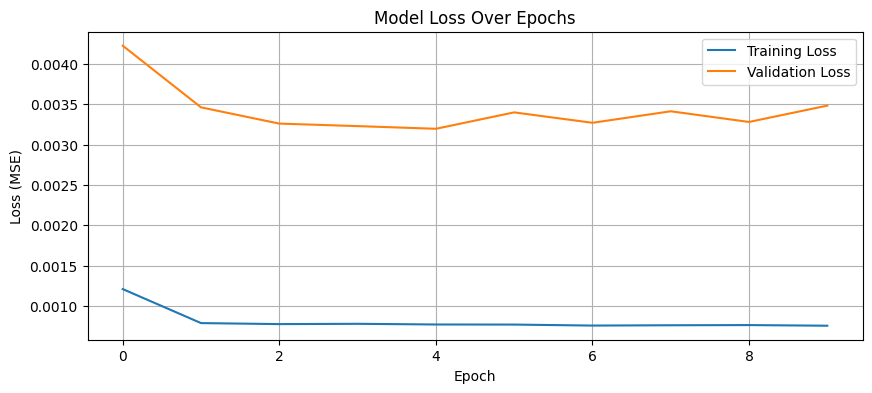

In [ ]:
plot_loss(history_base)

In [ ]:
# Evaluate and Inverse Scale Predictions
# Predict
y_pred = model_base.predict(X_test)

# Inverse scale
y_test_inv_base = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv_base = scaler.inverse_transform(y_pred)

evaluation_metrics(y_test_inv_base, y_pred_inv_base, label = 'model_base', cutoff_date = cutoff_date, results_df = HH_results_df, features = ['HH_Price'])



41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
model_base                     | MAE:  0.808  MSE:  1.436  RMSE:  1.198  R²:  0.666


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_base,0.807688,1.43597,1.19832,0.666337,2021-12-31,HH_Price


In [ ]:
# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_inv_base)]

y_pred_series = pd.Series(y_pred_inv_base.flatten(), index=forecast_dates)
y_test_series = pd.Series(y_test_inv_base.flatten(), index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label = 'model_base_war', cutoff_date = cutoff_date, results_df = HH_results_df, features = ['HH_Price']
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label = 'model_base_PostWar', cutoff_date = cutoff_date, results_df = HH_results_df, features = ['HH_Price'])

model_base_war                 | MAE:  1.337  MSE:  2.621  RMSE:  1.619  R²:  0.413
model_base_PostWar             | MAE:  0.519  MSE:  0.789  RMSE:  0.888  R²:  0.178


In [ ]:
# Calculate forecast dates based on the test set
# The first forecast date corresponds to the end of the first window in the test set
# The last forecast date corresponds to the end of the last window in the test set
forecast_dates = df_selected_features.index[window_size - 1 : -(horizon_days)]
forecast_dates = forecast_dates[split_idx + 1 - buffer:]

save_path = '/content/drive/My Drive/BKW/reports'

import kaleido

fig = plot_lstm_forecast_aligned_to_forecast_date(
    df_all=df_hh,
    forecast_dates=forecast_dates,
    y_pred_inv=y_pred_inv_base,
    y_true_inv=y_test_inv_base,
    horizon_days=horizon_days,
    title='HH Price Forecast (Aligned to Forecast Date) by base LSTM model',
    # save_path=save_path # Commented out to prevent image export error
)

# Compute metrics
mae_war = mean_absolute_error(y_test_series[war_mask], y_pred_series[war_mask])
r2_war = r2_score(y_test_series[war_mask], y_pred_series[war_mask])

mae_postwar = mean_absolute_error(y_test_series[postwar_mask], y_pred_series[postwar_mask])
r2_postwar = r2_score(y_test_series[postwar_mask], y_pred_series[postwar_mask])


# Add shaded boxes
fig.add_shape(
    type="rect",
    x0="2022-01-01", x1="2023-03-31",
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightSalmon",
    opacity=0.2,
    layer="below",
    line_width=0,
)

fig.add_shape(
    type="rect",
    x0="2023-04-01", x1=forecast_dates[-1],
    y0=fig.layout.yaxis.range[0] if fig.layout.yaxis.range else y_test_series.min(),
    y1=fig.layout.yaxis.range[1] if fig.layout.yaxis.range else y_test_series.max(),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    line_width=0,
)

# Add annotations
fig.add_annotation(
    text=f"War Period<br>MAE: {mae_war:.2f}<br>R²: {r2_war:.2f}",
    x="2022-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightSalmon",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.add_annotation(
    text=f"Post-War Period<br>MAE: {mae_postwar:.2f}<br>R²: {r2_postwar:.2f}",
    x="2024-07-01",
    y=max(y_test_series.max(), y_pred_series.max()),
    showarrow=False,
    bgcolor="LightGreen",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)
fig.show()



In [ ]:
# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "HH_forecast_plot_by_base_model.html"))

In [ ]:
# Save and reload the model
save_model_and_history(model_base, history_base, '/content/drive/My Drive/BKW/Models', model_name='HH_base_lstm_model')

✅ Model saved to: /content/drive/My Drive/BKW/Models/HH_base_lstm_model.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/HH_base_lstm_model_history.pkl


X_train shape: (4140, 365, 20)
X_test shape: (1289, 365, 20)
y_train shape: (4140,)
y_test shape: (1289,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 47s 357ms/step - loss: 0.0044 - mae: 0.0486 - mape: 76.3189 - rmse: 0.0641 - val_loss: 0.0050 - val_mae: 0.0385 - val_mape: 33.1507 - val_rmse: 0.0710 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 79s 333ms/step - loss: 8.3590e-04 - mae: 0.0217 - mape: 31.7898 - rmse: 0.0289 - val_loss: 0.0046 - val_mae: 0.0346 - val_mape: 29.1273 - val_rmse: 0.0679 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - loss: 5.9497e-04 - mae: 0.0187 - mape: 27.7158 - rmse: 0.0244 - val_loss: 0.0047 - val_mae: 0.0370 - val_mape: 31.5028 - val_rmse: 0.0685 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 39s 315ms/step - loss: 5.7010e-04 - mae: 0.0178 - mape: 26.8388 - rmse: 0.0239 - val_loss: 0.0045 - val_mae: 0.0338 - val_mape: 28.4529 - val_rmse: 0.0669 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━

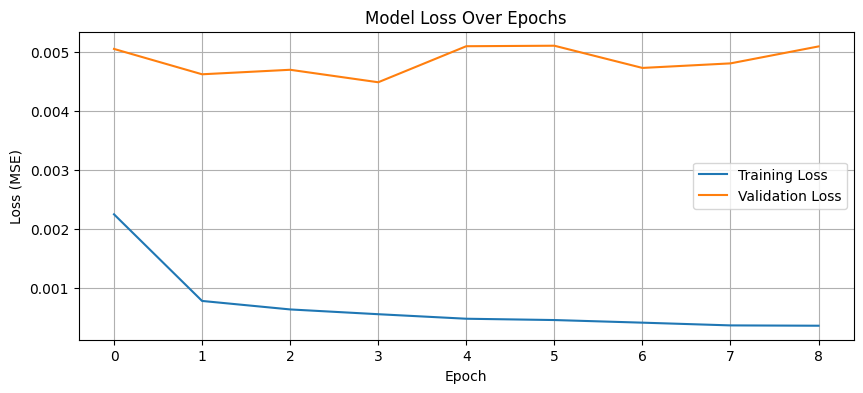

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
model_multi_all20_total        | MAE:  0.933  MSE:  1.696  RMSE:  1.302  R²:  0.606
model_multi_all20_War          | MAE:  1.503  MSE:  3.297  RMSE:  1.816  R²:  0.262
model_multi_all20_PostWar      | MAE:  0.623  MSE:  0.822  RMSE:  0.907  R²:  0.144


In [ ]:
#@title model_multi_all20 with all 20 features

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'Brent_Price', 'Brent_Volume', 'TTFMc1_Close',
       'TTFMc2_Close', 'TTF_Price', 'Coal_Price',
       'CBOE_Price', 'TTFMc3_Close',   'NBP_Price',
       'month', 'sin_day', 'cos_day', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_all20 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_all20.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_all20 = model_multi_all20.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_all20)

#@title Evaluate the model_multi_all20 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_all20.predict(X_test)

# Inverse just the price component
y_pred_multi_all20 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi_all20 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi_all20, y_pred_multi_all20, label = 'model_multi_all20_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi_all20)]

y_pred_series = pd.Series(y_pred_multi_all20, index=forecast_dates)
y_test_series = pd.Series(y_test_multi_all20, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_all20_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_all20_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

In [ ]:
HH_results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_multi_all20_total,0.889499,1.400678,1.183502,0.674537,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
1,model_multi_all20_War,1.318709,2.416232,1.554423,0.458856,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
2,model_multi_all20_PostWar,0.655338,0.846629,0.920124,0.118753,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."


# Adding weather informaton to the selected features

In [ ]:
weather_17cities = pd.read_csv('/content/drive/My Drive/BKW/LNG Project data/DATA from 2009 (on progress)/temperature_data_17_cities.csv')
weather_17cities.head()

,Date,Temperature_C_london,Temperature_C_rome,Temperature_C_milan,Temperature_C_sabine,Temperature_C_singapore,Temperature_C_delhi,Temperature_C_paris,Temperature_C_amsterdam,Temperature_C_berlin,Temperature_C_beijing,Temperature_C_houston,Temperature_C_shanghai,Temperature_C_madrid,Temperature_C_seoul,Temperature_C_tokyo,Temperature_C_warsaw,Temperature_C_barcelona,Temperature_C_marseille
0,2009-01-01 12:00:00,1.846138,13.580338,1.992233,7.411224,26.309921,16.165758,0.908600,0.673180,-2.235992,-6.122121,5.121313,2.170712,9.691338,-5.379903,4.017929,-5.368154,11.900238,11.719856
1,2009-01-02 12:00:00,3.273895,10.781517,1.215401,17.460213,25.817940,16.795279,-0.377472,1.966638,-0.502858,-3.983917,16.989355,3.369029,10.240242,-3.126424,5.143845,-3.340739,11.455139,10.090485
2,2009-01-03 12:00:00,1.974323,9.509331,2.645218,19.125930,25.051865,14.942780,0.598160,0.292769,-3.778478,-1.592072,20.784607,5.991187,8.282448,-0.836192,5.532623,-3.505549,10.173637,9.825676
3,2009-01-04 12:00:00,-0.604515,8.123077,1.895592,19.405067,25.895980,16.174082,-1.466522,3.761017,0.667653,-4.921519,20.936377,5.920325,8.404343,-0.861674,5.967667,-3.685633,9.266777,6.503151
4,2009-01-05 12:00:00,1.951569,8.828506,0.696831,12.930420,26.153183,16.895670,-0.016713,-1.222466,-6.190801,-5.862671,8.850789,7.144284,1.949745,-3.284261,6.623154,-10.223892,8.356987,6.070435


In [ ]:
weather_17cities['Date'] = pd.to_datetime(weather_17cities['Date']).dt.normalize()
weather_17cities.head()

,Date,Temperature_C_london,Temperature_C_rome,Temperature_C_milan,Temperature_C_sabine,Temperature_C_singapore,Temperature_C_delhi,Temperature_C_paris,Temperature_C_amsterdam,Temperature_C_berlin,Temperature_C_beijing,Temperature_C_houston,Temperature_C_shanghai,Temperature_C_madrid,Temperature_C_seoul,Temperature_C_tokyo,Temperature_C_warsaw,Temperature_C_barcelona,Temperature_C_marseille
0,2009-01-01,1.846138,13.580338,1.992233,7.411224,26.309921,16.165758,0.908600,0.673180,-2.235992,-6.122121,5.121313,2.170712,9.691338,-5.379903,4.017929,-5.368154,11.900238,11.719856
1,2009-01-02,3.273895,10.781517,1.215401,17.460213,25.817940,16.795279,-0.377472,1.966638,-0.502858,-3.983917,16.989355,3.369029,10.240242,-3.126424,5.143845,-3.340739,11.455139,10.090485
2,2009-01-03,1.974323,9.509331,2.645218,19.125930,25.051865,14.942780,0.598160,0.292769,-3.778478,-1.592072,20.784607,5.991187,8.282448,-0.836192,5.532623,-3.505549,10.173637,9.825676
3,2009-01-04,-0.604515,8.123077,1.895592,19.405067,25.895980,16.174082,-1.466522,3.761017,0.667653,-4.921519,20.936377,5.920325,8.404343,-0.861674,5.967667,-3.685633,9.266777,6.503151
4,2009-01-05,1.951569,8.828506,0.696831,12.930420,26.153183,16.895670,-0.016713,-1.222466,-6.190801,-5.862671,8.850789,7.144284,1.949745,-3.284261,6.623154,-10.223892,8.356987,6.070435


In [ ]:
weather_houston = weather_17cities[['Date','Temperature_C_houston']]
weather_houston.head()

,Date,Temperature_C_houston
0,2009-01-01,5.121313
1,2009-01-02,16.989355
2,2009-01-03,20.784607
3,2009-01-04,20.936377
4,2009-01-05,8.850789


In [ ]:
weather_6regions = pd.read_csv('/content/drive/My Drive/BKW/LNG Project data/DATA from 2009 (on progress)/temperature_data_6_regions.csv')

In [ ]:
weather_6regions['date']= pd.to_datetime(weather_6regions['date']).dt.date
weather_6regions.head()

,date,jkm,hh,ttf,psv,pvb,peg
0,2009-01-01,6.193716,6.266269,0.094442,7.786285,10.795788,6.314228
1,2009-01-02,7.335959,17.224785,1.579225,5.998459,10.847691,4.856506
2,2009-01-03,8.181699,19.955269,-0.503795,6.077274,9.228043,5.211918
3,2009-01-04,8.029143,20.170723,1.274718,5.009335,8.835560,2.518314
4,2009-01-05,7.944893,10.890604,-1.820566,4.762669,5.153366,3.026861


In [ ]:
weather_hh = weather_6regions[['date', 'hh']]
weather_hh.head()


,date,hh
0,2009-01-01,6.266269
1,2009-01-02,17.224785
2,2009-01-03,19.955269
3,2009-01-04,20.170723
4,2009-01-05,10.890604


In [ ]:
weather_hh.rename(columns={'date': 'Date', 'hh': 'hh_reg_temp'}, inplace=True)
weather_hh.head()

/tmp/ipython-input-46-2169861711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_hh.rename(columns={'date': 'Date', 'hh': 'hh_reg_temp'}, inplace=True)


,Date,hh_reg_temp
0,2009-01-01,6.266269
1,2009-01-02,17.224785
2,2009-01-03,19.955269
3,2009-01-04,20.170723
4,2009-01-05,10.890604


In [ ]:
weather_hh['Date'] = pd.to_datetime(weather_hh['Date'])
weather_houston['Date'] = pd.to_datetime(weather_houston['Date'])
weather = pd.merge(weather_hh.copy(), weather_houston.copy(), on='Date', how='left')
weather.head()

/tmp/ipython-input-47-780753829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_hh['Date'] = pd.to_datetime(weather_hh['Date'])
/tmp/ipython-input-47-780753829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_houston['Date'] = pd.to_datetime(weather_houston['Date'])


,Date,hh_reg_temp,Temperature_C_houston
0,2009-01-01,6.266269,5.121313
1,2009-01-02,17.224785,16.989355
2,2009-01-03,19.955269,20.784607
3,2009-01-04,20.170723,20.936377
4,2009-01-05,10.890604,8.850789


In [ ]:
weather.set_index('Date', inplace=True)
weather.head()

,hh_reg_temp,Temperature_C_houston
Date,,
2009-01-01,6.266269,5.121313
2009-01-02,17.224785,16.989355
2009-01-03,19.955269,20.784607
2009-01-04,20.170723,20.936377
2009-01-05,10.890604,8.850789


In [ ]:
weather_sorted = weather.sort_values(by='Temperature_C_houston')
weather_sorted.head(10)

,hh_reg_temp,Temperature_C_houston
Date,,
2021-02-16,-8.762312,-11.282924
2022-12-23,-6.567980,-8.320638
2021-02-15,-5.032039,-7.968404
2025-01-22,-7.556439,-7.839686
2018-01-17,-6.048551,-7.223750
2010-01-09,-5.036247,-6.608185
2024-01-17,-5.127843,-6.507548
2024-01-16,-5.002194,-6.342738
2011-02-02,-3.925514,-5.412201


In [ ]:
df_selected_features = pd.merge(df_selected_features, weather, left_index=True, right_index=True)
df_selected_features.head()

,NetImports_Total,Brent_Price,Brent_Volume,TTFMc1_Close,TTFMc2_Close,TTF_Price,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,...,HH_Return,MA_7,Volatility_30,return_30,return_60,rolling_std_30,z_score_30,bollinger_width,hh_reg_temp,Temperature_C_houston
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-03,-260369.0,73.55,112160.0,9.00,12.05,8.85,70.63,8.50,9.50,25.56,...,0.008824,3.397143,0.111789,0.019316,-0.041899,0.028036,0.583688,0.132894,26.320007,25.419168
2009-08-04,72918.0,74.28,93960.0,9.45,12.25,9.45,73.75,8.95,9.95,24.89,...,0.029155,3.402857,0.115088,0.068887,0.005698,0.028239,1.369962,0.136509,25.934452,24.892600
2009-08-05,-295228.0,75.51,117950.0,9.37,12.19,9.25,73.65,8.87,9.87,24.90,...,0.022663,3.431429,0.120133,0.114198,0.026540,0.028166,1.875703,0.141973,26.027233,25.244452
2009-08-06,-476344.0,74.83,126860.0,9.58,12.46,9.25,74.25,9.08,10.08,25.67,...,0.047091,3.494286,0.138957,0.145455,0.072848,0.029140,2.729856,0.163447,26.438510,25.594614
2009-08-07,-110475.0,73.59,103290.0,9.57,12.46,9.23,74.05,9.07,10.07,24.76,...,-0.055556,3.527143,0.137955,0.108696,0.011331,0.030739,1.142886,0.161713,25.877163,25.022451


In [14]:
# df_selected_features.to_csv('/content/drive/My Drive/BKW/LNG Project data/DATA from 2009 (on progress)/df_selected_features_hh_jz.csv')
df_selected_features = pd.read_csv('/content/drive/My Drive/BKW/LNG Project data/DATA from 2009 (on progress)/df_selected_features_hh_jz.csv')

In [15]:
df_selected_features['Date'] = pd.to_datetime(df_selected_features['Date'])
df_selected_features.set_index('Date', inplace=True)
df_selected_features.head()

,NetImports_Total,Brent_Price,Brent_Volume,TTFMc1_Close,TTFMc2_Close,TTF_Price,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,...,HH_Return,MA_7,Volatility_30,return_30,return_60,rolling_std_30,z_score_30,bollinger_width,hh_reg_temp,Temperature_C_houston
Date,,,,,,,,,,,,,,,,,,,,,
2009-08-03,-260369.0,73.55,112160.0,9.00,12.05,8.85,70.63,8.50,9.50,25.56,...,0.008824,3.397143,0.111789,0.019316,-0.041899,0.028036,0.583688,0.132894,26.320007,25.419168
2009-08-04,72918.0,74.28,93960.0,9.45,12.25,9.45,73.75,8.95,9.95,24.89,...,0.029155,3.402857,0.115088,0.068887,0.005698,0.028239,1.369962,0.136509,25.934452,24.892600
2009-08-05,-295228.0,75.51,117950.0,9.37,12.19,9.25,73.65,8.87,9.87,24.90,...,0.022663,3.431429,0.120133,0.114198,0.026540,0.028166,1.875703,0.141973,26.027233,25.244452
2009-08-06,-476344.0,74.83,126860.0,9.58,12.46,9.25,74.25,9.08,10.08,25.67,...,0.047091,3.494286,0.138957,0.145455,0.072848,0.029140,2.729856,0.163447,26.438510,25.594614
2009-08-07,-110475.0,73.59,103290.0,9.57,12.46,9.23,74.05,9.07,10.07,24.76,...,-0.055556,3.527143,0.137955,0.108696,0.011331,0.030739,1.142886,0.161713,25.877163,25.022451


In [16]:
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5821 entries, 2009-08-03 to 2025-07-10
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NetImports_Total       5821 non-null   float64
 1   Brent_Price            5821 non-null   float64
 2   Brent_Volume           5821 non-null   float64
 3   TTFMc1_Close           5821 non-null   float64
 4   TTFMc2_Close           5821 non-null   float64
 5   TTF_Price              5821 non-null   float64
 6   Coal_Price             5821 non-null   float64
 7   TTFMc1_Bid             5821 non-null   float64
 8   TTFMc1_Ask             5821 non-null   float64
 9   CBOE_Price             5821 non-null   float64
 10  TTFMc3_Close           5821 non-null   float64
 11  TTFMc2_Bid             5821 non-null   float64
 12  HH_Price               5821 non-null   float64
 13  NBP_Price              5821 non-null   float64
 14  month                  5821 non-null  

In [17]:
df_selected_features.columns

Index(['NetImports_Total', 'Brent_Price', 'Brent_Volume', 'TTFMc1_Close',
       'TTFMc2_Close', 'TTF_Price', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask',
       'CBOE_Price', 'TTFMc3_Close', 'TTFMc2_Bid', 'HH_Price', 'NBP_Price',
       'month', 'sin_day', 'cos_day', 'HH_Return', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width', 'hh_reg_temp', 'Temperature_C_houston'],
      dtype='object')

X_train shape: (4140, 365, 21)
X_test shape: (1287, 365, 21)
y_train shape: (4140,)
y_test shape: (1287,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 43s 328ms/step - loss: 0.0055 - mae: 0.0543 - mape: 79.7032 - rmse: 0.0716 - val_loss: 0.0045 - val_mae: 0.0327 - val_mape: 27.7641 - val_rmse: 0.0674 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 37s 316ms/step - loss: 0.0011 - mae: 0.0251 - mape: 39.0653 - rmse: 0.0325 - val_loss: 0.0045 - val_mae: 0.0342 - val_mape: 28.8999 - val_rmse: 0.0673 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - loss: 8.2903e-04 - mae: 0.0217 - mape: 31.6910 - rmse: 0.0288 - val_loss: 0.0041 - val_mae: 0.0289 - val_mape: 24.3107 - val_rmse: 0.0638 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - loss: 6.3150e-04 - mae: 0.0192 - mape: 28.0971 - rmse: 0.0251 - val_loss: 0.0044 - val_mae: 0.0319 - val_mape: 26.1550 - val_rmse: 0.0664 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━

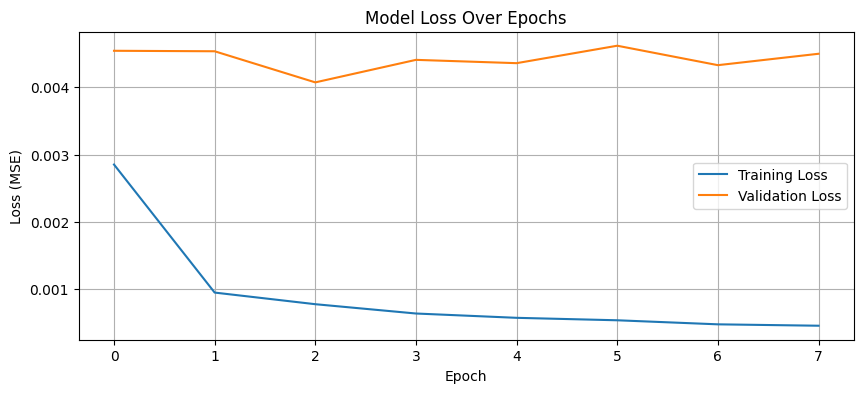

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
model_multi_all21_total        | MAE:  0.878  MSE:  1.517  RMSE:  1.232  R²:  0.648
model_multi_all21_War          | MAE:  1.365  MSE:  2.795  RMSE:  1.672  R²:  0.374
model_multi_all21_PostWar      | MAE:  0.612  MSE:  0.819  RMSE:  0.905  R²:  0.149


In [ ]:
#@title model_multi_all21 with all 20 features and weather

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'Brent_Price', 'Brent_Volume', 'TTFMc1_Close',
       'TTFMc2_Close', 'TTF_Price', 'Coal_Price',
       'CBOE_Price', 'TTFMc3_Close',   'NBP_Price',
       'month', 'sin_day', 'cos_day', 'MA_7', 'Volatility_30',
       'return_30', 'return_60', 'rolling_std_30', 'z_score_30',
       'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi_all21 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi_all21.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi_all21 = model_multi_all21.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi_all21)

#@title Evaluate the model_multi_all21 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi_all21.predict(X_test)

# Inverse just the price component
y_pred_multi_all21 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi_all21 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi_all21, y_pred_multi_all21, label = 'model_multi_all21_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi_all21)]

y_pred_series = pd.Series(y_pred_multi_all21, index=forecast_dates)
y_test_series = pd.Series(y_test_multi_all21, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi_all21_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi_all21_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

X_train shape: (4140, 365, 5)
X_test shape: (1287, 365, 5)
y_train shape: (4140,)
y_test shape: (1287,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 45s 343ms/step - loss: 0.0021 - mae: 0.0344 - mape: 55.2357 - rmse: 0.0450 - val_loss: 0.0060 - val_mae: 0.0413 - val_mape: 35.8640 - val_rmse: 0.0775 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 422ms/step - loss: 6.8109e-04 - mae: 0.0199 - mape: 28.8579 - rmse: 0.0261 - val_loss: 0.0053 - val_mae: 0.0361 - val_mape: 30.9221 - val_rmse: 0.0728 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 77s 376ms/step - loss: 5.4762e-04 - mae: 0.0178 - mape: 26.5368 - rmse: 0.0234 - val_loss: 0.0051 - val_mae: 0.0372 - val_mape: 31.9955 - val_rmse: 0.0711 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - loss: 5.7835e-04 - mae: 0.0179 - mape: 26.1695 - rmse: 0.0240 - val_loss: 0.0055 - val_mae: 0.0376 - val_mape: 32.1272 - val_rmse: 0.0743 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━

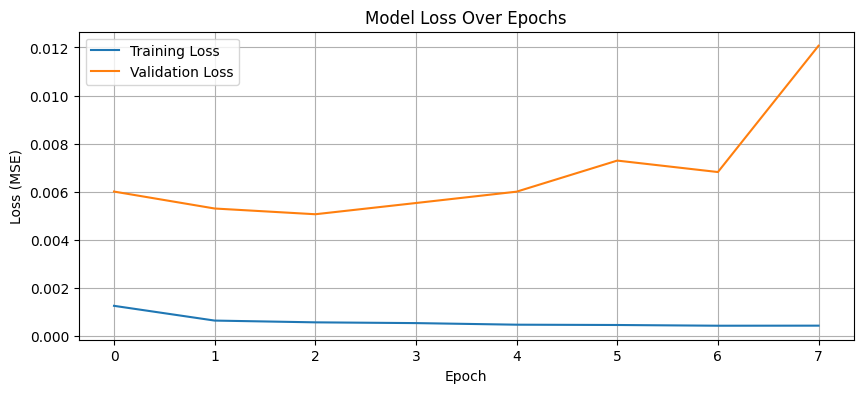

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
model_multi5_total             | MAE:  1.035  MSE:  2.715  RMSE:  1.648  R²:  0.370
model_multi5_War               | MAE:  1.879  MSE:  6.285  RMSE:  2.507  R²: -0.408
model_multi5_PostWar           | MAE:  0.573  MSE:  0.763  RMSE:  0.873  R²:  0.207


In [ ]:
#@title model_multi5 with all selected top index prices, bollinger_with and weather

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'TTF_Price', 'NBP_Price',
       'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi5 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi5.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi5 = model_multi5.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi5)

#@title Evaluate the model_multi5 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi5.predict(X_test)

# Inverse just the price component
y_pred_multi5 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi5 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi5, y_pred_multi5, label = 'model_multi5_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi5)]

y_pred_series = pd.Series(y_pred_multi5, index=forecast_dates)
y_test_series = pd.Series(y_test_multi5, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi5_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi5_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

X_train shape: (4140, 365, 3)
X_test shape: (1287, 365, 3)
y_train shape: (4140,)
y_test shape: (1287,)
Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - loss: 0.0022 - mae: 0.0343 - mape: 53.4114 - rmse: 0.0457 - val_loss: 0.0045 - val_mae: 0.0329 - val_mape: 30.8348 - val_rmse: 0.0673 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 317ms/step - loss: 6.1439e-04 - mae: 0.0189 - mape: 29.7426 - rmse: 0.0248 - val_loss: 0.0053 - val_mae: 0.0426 - val_mape: 39.0419 - val_rmse: 0.0727 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 35s 301ms/step - loss: 5.6017e-04 - mae: 0.0176 - mape: 26.1091 - rmse: 0.0237 - val_loss: 0.0053 - val_mae: 0.0425 - val_mape: 39.6665 - val_rmse: 0.0725 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 5.5076e-04 - mae: 0.0173 - mape: 26.0205 - rmse: 0.0234
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117/117 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - los

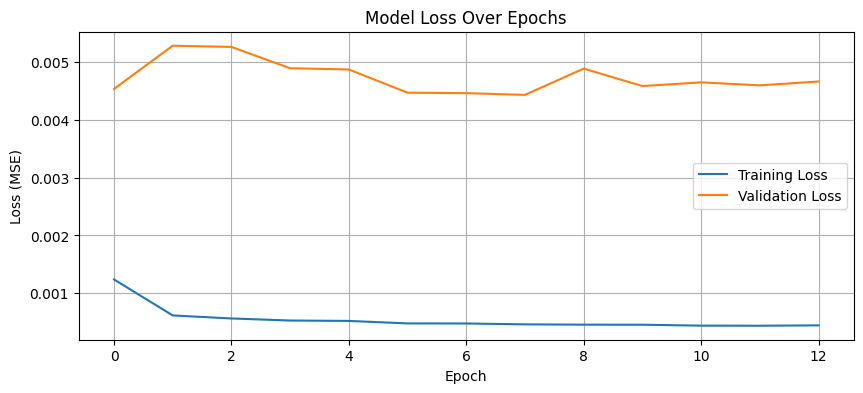

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
model_multi3_total             | MAE:  0.824  MSE:  1.503  RMSE:  1.226  R²:  0.651
model_multi3_War               | MAE:  1.411  MSE:  2.850  RMSE:  1.688  R²:  0.362
model_multi3_PostWar           | MAE:  0.503  MSE:  0.767  RMSE:  0.876  R²:  0.203


In [ ]:
#@title model_multi3 with all selected top index prices, bollinger_with and weather

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi3 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi3.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi3 = model_multi3.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi3)

#@title Evaluate the model_multi3 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi3.predict(X_test)

# Inverse just the price component
y_pred_multi3 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

evaluation_metrics(y_test_multi3, y_pred_multi3, label = 'model_multi3_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi3)]

y_pred_series = pd.Series(y_pred_multi3, index=forecast_dates)
y_test_series = pd.Series(y_test_multi3, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi3_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi3_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

In [ ]:
HH_results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_multi_all20_total,0.889499,1.400678,1.183502,0.674537,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
1,model_multi_all20_War,1.318709,2.416232,1.554423,0.458856,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
2,model_multi_all20_PostWar,0.655338,0.846629,0.920124,0.118753,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
3,model_multi_all21_total,0.878269,1.517401,1.231828,0.647936,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
4,model_multi_all21_War,1.365394,2.795074,1.671847,0.374009,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
5,model_multi_all21_PostWar,0.611873,0.818673,0.904805,0.149089,2021-12-31,"HH_Price, Brent_Price, Brent_Volume, TTFMc1_Cl..."
6,model_multi5_total,1.034756,2.715233,1.647796,0.370018,2021-12-31,"HH_Price, TTF_Price, NBP_Price, bollinger_widt..."
7,model_multi5_War,1.878958,6.285460,2.507082,-0.407705,2021-12-31,"HH_Price, TTF_Price, NBP_Price, bollinger_widt..."
8,model_multi5_PostWar,0.573082,0.762765,0.873364,0.207198,2021-12-31,"HH_Price, TTF_Price, NBP_Price, bollinger_widt..."
9,model_multi3_total,0.824157,1.503421,1.226141,0.651180,2021-12-31,"HH_Price, bollinger_width, Temperature_C_houston"


# Gridsearch HH LSTM model input

Run step by step grid search on cutoff_date, window_sizes, Horizon_days, lstm_units and dropout rates

In [ ]:
# === CONFIGURATION ===
cutoff_dates = ['2021-12-31', '2022-12-31', '2023-03-31']  # Run one at a time
current_cutoff = '2021-12-31'  # <-- CHANGE THIS before each run

# Save location
save_dir = "/content/drive/My Drive/BKW/Models/"
os.makedirs(save_dir, exist_ok=True)
save_file = f"{save_dir}grid_search_HH_{current_cutoff}.csv"

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]

# Features
feature_cols = ['HH_Price', 'bollinger_width', 'Temperature_C_houston']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Locate split index
try:
    split_idx = df_selected_features.index.get_loc(current_cutoff)
except KeyError:
    raise ValueError(f"Cutoff date {current_cutoff} not found in the index.")

experiment_results = []

# Grid search loop
for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons ({window_size})', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except Exception as e:
            print(f"❌ Sequence creation failed — skipping window={window_size}, horizon={horizon_days}")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too little training data for window={window_size}, horizon={horizon_days}")
            continue

        # Train/Val split
        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in tqdm(lstm_units_list, desc='LSTM Layers', leave=False):
            for drop1, drop2 in tqdm(dropout_configs, desc='Dropout Rates', leave=False):
                K.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                # Evaluation
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': current_cutoff,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })

                # 🧪 Live backup
                pd.DataFrame(experiment_results).to_csv(save_file, index=False)

print(f"✅ Grid search for cutoff {current_cutoff} completed and saved to:")
print(save_file)

Horizons (90):   0%|          | 0/3 [00:00<?, ?it/s]

LSTM Layers:   0%|          | 0/2 [00:00<?, ?it/s]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:26<00:53, 26.77s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:46<00:22, 22.87s/it]


Dropout Rates: 100%|██████████| 3/3 [00:58<00:00, 17.49s/it]


                                                            

LSTM Layers:  50%|█████     | 1/2 [00:58<00:58, 58.01s/it]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:13<00:27, 13.82s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:29<00:14, 14.62s/it]


Dropout Rates: 100%|██████████| 3/3 [00:46<00:00, 16.10s/it]


                                                            

LSTM Layers: 100%|██████████| 2/2 [01:44<00:00, 51.46s/it]

                                                          
Horizons (90):  33%|███▎      | 1/3 [01:44<03:29, 104.91s/it]

LSTM Layers:   0%|          | 0/2 [00:

✅ Grid search for cutoff 2021-12-31 completed and saved to:
/content/drive/My Drive/BKW/Models/grid_search_HH_2021-12-31.csv


In [ ]:
# @title current_cutoff = '2023-03-31'
# === CONFIGURATION ===
cutoff_dates = ['2021-12-31', '2022-12-31', '2023-03-31']  # Run one at a time
current_cutoff = '2023-03-31'  # <-- CHANGE THIS before each run

# Save location
save_dir = "/content/drive/My Drive/BKW/Models/"
os.makedirs(save_dir, exist_ok=True)
save_file = f"{save_dir}grid_search_HH_{current_cutoff}.csv"

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]

# Features
feature_cols = ['HH_Price', 'bollinger_width', 'Temperature_C_houston']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Locate split index
try:
    split_idx = df_selected_features.index.get_loc(current_cutoff)
except KeyError:
    raise ValueError(f"Cutoff date {current_cutoff} not found in the index.")

experiment_results = []

# Grid search loop
for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons ({window_size})', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except Exception as e:
            print(f"❌ Sequence creation failed — skipping window={window_size}, horizon={horizon_days}")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too little training data for window={window_size}, horizon={horizon_days}")
            continue

        # Train/Val split
        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in tqdm(lstm_units_list, desc='LSTM Layers', leave=False):
            for drop1, drop2 in tqdm(dropout_configs, desc='Dropout Rates', leave=False):
                K.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                # Evaluation
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': current_cutoff,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })

                # 🧪 Live backup
                pd.DataFrame(experiment_results).to_csv(save_file, index=False)

print(f"✅ Grid search for cutoff {current_cutoff} completed and saved to:")
print(save_file)

Horizons (90):   0%|          | 0/3 [00:00<?, ?it/s]

LSTM Layers:   0%|          | 0/2 [00:00<?, ?it/s]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:13<00:26, 13.42s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:26<00:13, 13.49s/it]


Dropout Rates: 100%|██████████| 3/3 [00:43<00:00, 14.80s/it]


                                                            

LSTM Layers:  50%|█████     | 1/2 [00:43<00:43, 43.33s/it]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:16<00:33, 16.51s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:33<00:16, 16.52s/it]


Dropout Rates: 100%|██████████| 3/3 [00:52<00:00, 17.84s/it]


                                                            

LSTM Layers: 100%|██████████| 2/2 [01:35<00:00, 48.69s/it]

                                                          
Horizons (90):  33%|███▎      | 1/3 [01:35<03:11, 95.80s/it]

LSTM Layers:   0%|          | 0/2 [00:0

✅ Grid search for cutoff 2023-03-31 completed and saved to:
/content/drive/My Drive/BKW/Models/grid_search_HH_2023-03-31.csv


In [ ]:
# @title current_cutoff = '2022-12-31'

# === CONFIGURATION ===
cutoff_dates = ['2021-12-31', '2022-12-31', '2023-03-31']  # Run one at a time
current_cutoff = '2022-12-31'  # <-- CHANGE THIS before each run

# Save location
save_dir = "/content/drive/My Drive/BKW/Models/"
os.makedirs(save_dir, exist_ok=True)
save_file = f"{save_dir}grid_search_HH_{current_cutoff}.csv"

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.2, 0.1), (0.4, 0.2), (0.5, 0.3)]

# Features
feature_cols = ['HH_Price', 'bollinger_width', 'Temperature_C_houston']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Locate split index
try:
    split_idx = df_selected_features.index.get_loc(current_cutoff)
except KeyError:
    raise ValueError(f"Cutoff date {current_cutoff} not found in the index.")

experiment_results = []

# Grid search loop
for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons ({window_size})', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except Exception as e:
            print(f"❌ Sequence creation failed — skipping window={window_size}, horizon={horizon_days}")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too little training data for window={window_size}, horizon={horizon_days}")
            continue

        # Train/Val split
        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in tqdm(lstm_units_list, desc='LSTM Layers', leave=False):
            for drop1, drop2 in tqdm(dropout_configs, desc='Dropout Rates', leave=False):
                K.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[
                        MeanAbsoluteError(name='mae'),
                        RootMeanSquaredError(name='rmse'),
                        MeanAbsolutePercentageError(name='mape')
                    ]
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                # Evaluation
                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': current_cutoff,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2
                })

                # 🧪 Live backup
                pd.DataFrame(experiment_results).to_csv(save_file, index=False)

print(f"✅ Grid search for cutoff {current_cutoff} completed and saved to:")
print(save_file)

Horizons (90):   0%|          | 0/3 [00:00<?, ?it/s]

LSTM Layers:   0%|          | 0/2 [00:00<?, ?it/s]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:15<00:30, 15.35s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:33<00:17, 17.06s/it]


Dropout Rates: 100%|██████████| 3/3 [00:53<00:00, 18.26s/it]


                                                            

LSTM Layers:  50%|█████     | 1/2 [00:53<00:53, 53.30s/it]


Dropout Rates:   0%|          | 0/3 [00:00<?, ?it/s]


Dropout Rates:  33%|███▎      | 1/3 [00:17<00:34, 17.13s/it]


Dropout Rates:  67%|██████▋   | 2/3 [00:35<00:17, 17.97s/it]


Dropout Rates: 100%|██████████| 3/3 [00:48<00:00, 15.63s/it]


                                                            

LSTM Layers: 100%|██████████| 2/2 [01:41<00:00, 50.50s/it]

                                                          
Horizons (90):  33%|███▎      | 1/3 [01:41<03:23, 101.86s/it]

LSTM Layers:   0%|          | 0/2 [00:

✅ Grid search for cutoff 2022-12-31 completed and saved to:
/content/drive/My Drive/BKW/Models/grid_search_HH_2022-12-31.csv


In [ ]:
files = [f'grid_search_HH_{d}.csv' for d in cutoff_dates]
df_all = pd.concat([pd.read_csv(os.path.join(save_dir, f)) for f in files])
df_all.head()

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2021-12-31,90,30,32,16,0.2,0.1,0.802991,1.207474,20.939027,0.661719
1,2021-12-31,90,30,32,16,0.4,0.2,0.837778,1.217953,22.827119,0.655823
2,2021-12-31,90,30,32,16,0.5,0.3,0.859376,1.228241,23.671570,0.649984
3,2021-12-31,90,30,64,32,0.2,0.1,0.828766,1.206617,22.352700,0.662200
4,2021-12-31,90,30,64,32,0.4,0.2,0.838659,1.196367,23.603915,0.667915


In [ ]:
df_all.to_csv(os.path.join(save_dir, 'grid_search_HH_all.csv'), index=False)


In [ ]:
save_dir = "/content/drive/My Drive/BKW/Models/"
df_grid_search = pd.read_csv(os.path.join(save_dir, 'grid_search_HH_all.csv'))
df_grid_search.head()

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2021-12-31,90,30,32,16,0.2,0.1,0.802991,1.207474,20.939027,0.661719
1,2021-12-31,90,30,32,16,0.4,0.2,0.837778,1.217953,22.827119,0.655823
2,2021-12-31,90,30,32,16,0.5,0.3,0.859376,1.228241,23.671570,0.649984
3,2021-12-31,90,30,64,32,0.2,0.1,0.828766,1.206617,22.352700,0.662200
4,2021-12-31,90,30,64,32,0.4,0.2,0.838659,1.196367,23.603915,0.667915


In [ ]:
best_rows = df_grid_search.loc[
    df_grid_search.groupby(['cutoff_date', 'horizon_days'])['R2'].idxmax()
].reset_index(drop=True)
best_rows

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2
0,2021-12-31,90,30,64,32,0.4,0.2,0.838659,1.196367,23.603915,0.667915
1,2021-12-31,180,60,64,32,0.5,0.3,0.979888,1.437721,27.272637,0.520410
2,2021-12-31,365,90,64,32,0.2,0.1,1.150789,1.567275,33.964823,0.430083
3,2022-12-31,180,30,64,32,0.2,0.1,0.550496,0.890143,20.882364,0.114275
4,2022-12-31,180,60,32,16,0.5,0.3,0.658124,1.035653,25.788649,-0.198970
5,2022-12-31,180,90,64,32,0.5,0.3,0.801964,1.177438,31.713237,-0.549727
6,2023-03-31,180,30,64,32,0.2,0.1,0.495909,0.851717,18.753477,0.246012
7,2023-03-31,180,60,32,16,0.5,0.3,0.578106,0.955141,22.623657,0.051781
8,2023-03-31,90,90,32,16,0.2,0.1,0.711671,1.043361,29.259150,-0.131470


# Best model setting for the forecast 30 days horizon

X_train shape: (4415, 90, 3)
X_test shape: (1287, 90, 3)
y_train shape: (4415,)
y_test shape: (1287,)
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0036 - mae: 0.0442 - mape: 65.2550 - rmse: 0.0578 - val_loss: 0.0054 - val_mae: 0.0444 - val_mape: 43.1623 - val_rmse: 0.0733 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3619e-04 - mae: 0.0216 - mape: 30.5460 - rmse: 0.0289 - val_loss: 0.0049 - val_mae: 0.0395 - val_mape: 36.2988 - val_rmse: 0.0699 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4261e-04 - mae: 0.0202 - mape: 28.6421 - rmse: 0.0272 - val_loss: 0.0047 - val_mae: 0.0373 - val_mape: 34.8737 - val_rmse: 0.0687 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7389e-04 - mae: 0.0188 - mape: 26.3292 - rmse: 0.0259 - val_loss: 0.0047 - val_mae: 0.0368 - val_mape: 34.4822 - val_rmse: 0.0685 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━

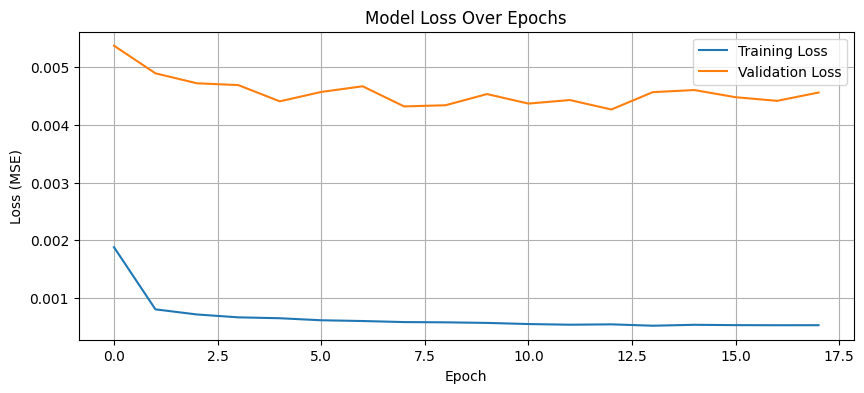

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
model_multi3_2021_30_total     | MAE:  0.802  MSE:  1.489  RMSE:  1.220  R²:  0.655
model_multi3_2021_30_War       | MAE:  1.357  MSE:  2.835  RMSE:  1.684  R²:  0.447
model_multi3_2021_30_PostWar   | MAE:  0.491  MSE:  0.753  RMSE:  0.868  R²:  0.239


In [ ]:
#@title model_multi3 with 30 days horizon best model setting from gridsearch
"""
according to the gridsearch results the best model setting for the 30 horizon is
window_size =90
lstm1 64
lstm2 32
drop1 0.4
drop2 0.2

"""
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi3_2021_30 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi3_2021_30.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi3_2021_30 = model_multi3_2021_30.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi3_2021_30)

#@title Evaluate the model_multi3 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi3_2021_30.predict(X_test)

# Inverse just the price component
y_pred_multi3_2021_30 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3_2021_30 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

HH_results_df = evaluation_metrics(y_test_multi3_2021_30, y_pred_multi3_2021_30, label = 'model_multi3_2021_30_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi3_2021_30)]

y_pred_series = pd.Series(y_pred_multi3_2021_30, index=forecast_dates)
y_test_series = pd.Series(y_test_multi3_2021_30, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
HH_results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi3_2021_30_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

HH_results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi3_2021_30_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

In [ ]:
save_model_and_history(model_multi3_2021_30,
                       history_multi3_2021_30,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='HH_lstm_model_multi3_2021_30')

✅ Model saved to: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_30.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_30_history.pkl


In [22]:
# load the model
model_loaded, history_loaded = load_model_and_history('/content/drive/My Drive/BKW/Models', model_name='HH_lstm_model_multi3_2021_30')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_30.keras
✅ History loaded from: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_30_history.pkl


In [28]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred_multi3_2021_30 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3_2021_30 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [29]:
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi3_2021_30)]

In [30]:
save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi3_2021_30,
    y_test_multi3_2021_30,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_30_forecast.csv'
)

✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_30_forecast.csv


,HH_Price,bollinger_width,Temperature_C_houston,Predicted_30D,Actual_30D
Date,,,,,
2009-08-03,3.43,0.132894,25.419168,<NA>,<NA>
2009-08-04,3.53,0.136509,24.892600,<NA>,<NA>
2009-08-05,3.61,0.141973,25.244452,<NA>,<NA>
2009-08-06,3.78,0.163447,25.594614,<NA>,<NA>
2009-08-07,3.57,0.161713,25.022451,<NA>,<NA>
...,...,...,...,...,...
2025-07-06,3.26,0.296394,24.364151,<NA>,<NA>
2025-07-07,3.26,0.288340,24.956750,<NA>,<NA>
2025-07-08,3.26,0.286521,25.646255,<NA>,<NA>


In [ ]:
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

In [31]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_30_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_30.keras'
window_size = 90          # e.g., 365 days of lookback
horizon_days = 30          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,HH_Price,bollinger_width,Temperature_C_houston,Predicted_30D,Actual_30D
Date,,,,,
2025-06-10,2.790000,0.205255,25.283361,3.053602,3.26
2025-06-11,2.730000,0.211925,24.329153,3.044148,NaN
2025-06-12,2.900000,0.202026,23.091543,3.039693,NaN
2025-06-13,2.650000,0.201577,24.276388,3.026403,NaN
2025-06-14,2.733333,0.200440,25.535751,3.010895,NaN
2025-06-15,2.816667,0.202558,25.681250,2.998658,NaN
2025-06-16,2.900000,0.202456,23.351309,2.994917,NaN
2025-06-17,2.900000,0.202506,24.573776,2.994394,NaN
2025-06-18,3.430000,0.236254,26.534323,3.015832,NaN


In [32]:
df.to_csv('/content/drive/My Drive/BKW/reports/HH_forecast/30d_prediction.csv')

# Best model setting for the forecast 60 days horizon

X_train shape: (4110, 365, 3)
X_test shape: (1287, 365, 3)
y_train shape: (4110,)
y_test shape: (1287,)
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0201 - mae: 0.0963 - mape: 142.7193 - rmse: 0.1301 - val_loss: 0.0060 - val_mae: 0.0465 - val_mape: 36.8543 - val_rmse: 0.0776 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0019 - mae: 0.0348 - mape: 55.2499 - rmse: 0.0437 - val_loss: 0.0068 - val_mae: 0.0531 - val_mape: 46.5744 - val_rmse: 0.0822 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0014 - mae: 0.0288 - mape: 44.9087 - rmse: 0.0368 - val_loss: 0.0064 - val_mae: 0.0519 - val_mape: 47.2516 - val_rmse: 0.0801 - learning_rate: 0.0010
Epoch 4/50
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011 - mae: 0.0264 - mape: 40.8286 - rmse: 0.0338
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011 - mae: 0.0

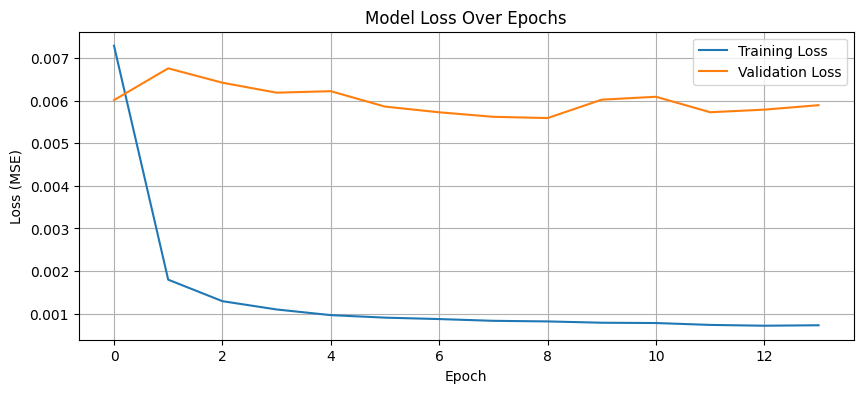

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
model_multi3_2021_60_total     | MAE:  0.985  MSE:  2.154  RMSE:  1.468  R²:  0.500
model_multi3_2021_60_War       | MAE:  1.618  MSE:  4.060  RMSE:  2.015  R²:  0.299
model_multi3_2021_60_PostWar   | MAE:  0.629  MSE:  1.138  RMSE:  1.067  R²: -0.121


In [ ]:
#@title model_multi3 with 60 days horizon best model setting from gridsearch
"""
according to the gridsearch results the best model setting for the 60 horizon is
window_size =365
lstm1 32
lstm2 16
drop1 0.4
drop2 0.2

"""
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 60
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi3_2021_60 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(16),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model_multi3_2021_60.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi3_2021_60 = model_multi3_2021_60.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi3_2021_60)

#@title Evaluate the model_multi3 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi3_2021_60.predict(X_test)

# Inverse just the price component
y_pred_multi3_2021_60 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3_2021_60 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

HH_results_df = evaluation_metrics(y_test_multi3_2021_60, y_pred_multi3_2021_60, label = 'model_multi3_2021_60_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi3_2021_60)]

y_pred_series = pd.Series(y_pred_multi3_2021_60, index=forecast_dates)
y_test_series = pd.Series(y_test_multi3_2021_60, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
HH_results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi3_2021_60_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

HH_results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi3_2021_60_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

In [18]:
save_model_and_history(model_multi3_2021_60,
                       history_multi3_2021_60,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='HH_lstm_model_multi3_2021_60')

NameError: name 'model_multi3_2021_60' is not defined

In [19]:
# load the model
model_loaded, history_loaded = load_model_and_history('/content/drive/My Drive/BKW/Models', model_name='HH_lstm_model_multi3_2021_60')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_60.keras
✅ History loaded from: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_60_history.pkl


In [22]:
#@title Reproduce the y_test and y_pred using the model loaded for 60 days horizon
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 60
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred_multi3_2021_60 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3_2021_60 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi3_2021_60,
    y_test_multi3_2021_60,
    horizon_days=60,
    save_path='/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_60_forecast.csv')


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_60_forecast.csv


,HH_Price,bollinger_width,Temperature_C_houston,Predicted_60D,Actual_60D
Date,,,,,
2009-08-03,3.43,0.132894,25.419168,<NA>,<NA>
2009-08-04,3.53,0.136509,24.892600,<NA>,<NA>
2009-08-05,3.61,0.141973,25.244452,<NA>,<NA>
2009-08-06,3.78,0.163447,25.594614,<NA>,<NA>
2009-08-07,3.57,0.161713,25.022451,<NA>,<NA>
...,...,...,...,...,...
2025-07-06,3.26,0.296394,24.364151,<NA>,<NA>
2025-07-07,3.26,0.288340,24.956750,<NA>,<NA>
2025-07-08,3.26,0.286521,25.646255,<NA>,<NA>


In [23]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_60_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_60.keras'
window_size = 365          # e.g., 365 days of lookback
horizon_days = 60          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,HH_Price,bollinger_width,Temperature_C_houston,Predicted_60D,Actual_60D
Date,,,,,
2025-05-11,3.20,0.246910,16.329153,2.986026,3.26
2025-05-12,3.19,0.233349,15.316228,2.998028,NaN
2025-05-13,3.27,0.215911,21.276367,3.018899,NaN
2025-05-14,3.31,0.192609,23.559067,3.045239,NaN
2025-05-15,3.20,0.190042,24.351517,3.070478,NaN
...,...,...,...,...,...
2025-07-06,3.26,0.296394,24.364151,3.179192,NaN
2025-07-07,3.26,0.288340,24.956750,3.179757,NaN
2025-07-08,3.26,0.286521,25.646255,3.181312,NaN


In [24]:
df.to_csv('/content/drive/My Drive/BKW/reports/HH_forecast/60d_prediction.csv')

In [ ]:
# Best model setting for the forecast 90 days horizon

X_train shape: (4265, 180, 3)
X_test shape: (1287, 180, 3)
y_train shape: (4265,)
y_test shape: (1287,)
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0023 - mae: 0.0376 - mape: 58.6518 - rmse: 0.0478 - val_loss: 0.0061 - val_mae: 0.0471 - val_mape: 36.5025 - val_rmse: 0.0782 - learning_rate: 0.0010
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.5373e-04 - mae: 0.0235 - mape: 35.6016 - rmse: 0.0308 - val_loss: 0.0061 - val_mae: 0.0470 - val_mape: 37.3950 - val_rmse: 0.0780 - learning_rate: 0.0010
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.0603e-04 - mae: 0.0231 - mape: 35.9358 - rmse: 0.0301 - val_loss: 0.0065 - val_mae: 0.0508 - val_mape: 41.2952 - val_rmse: 0.0805 - learning_rate: 0.0010
Epoch 4/50
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1976e-04 - mae: 0.0217 - mape: 32.6182 - rmse: 0.0286
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 8.1946

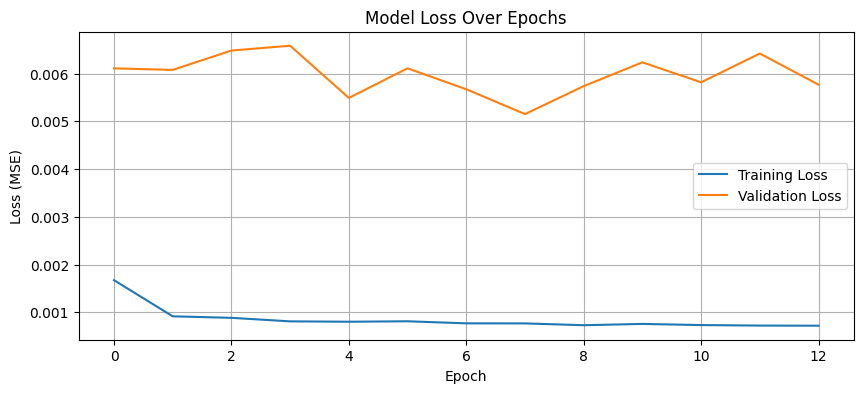

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
model_multi3_2021_90_total     | MAE:  1.117  MSE:  2.492  RMSE:  1.578  R²:  0.422
model_multi3_2021_90_War       | MAE:  1.879  MSE:  4.981  RMSE:  2.232  R²:  0.225
model_multi3_2021_90_PostWar   | MAE:  0.701  MSE:  1.175  RMSE:  1.084  R²: -0.128


In [ ]:
#@title model_multi3 with 90 days horizon best model setting from gridsearch
"""
according to the gridsearch results the best model setting for the 90 horizon is
window_size =180
lstm1 32
lstm2 16
drop1 0.2
drop2 0.1

"""
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['HH_Price', 'bollinger_width', 'Temperature_C_houston']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 90
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model_multi3_2021_90 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.2),
    LSTM(16),                            # Second LSTM layer outputs a vector
    Dropout(0.1),
    Dense(1)                             # Predict a single target value
])

model_multi3_2021_90.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history_multi3_2021_90 = model_multi3_2021_90.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history_multi3_2021_90)

#@title Evaluate the model_multi3 result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model_multi3_2021_90.predict(X_test)

# Inverse just the price component
y_pred_multi3_2021_90 = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test_multi3_2021_90 = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

HH_results_df = evaluation_metrics(y_test_multi3_2021_90, y_pred_multi3_2021_90, label = 'model_multi3_2021_90_total', cutoff_date = cutoff_date, results_df = HH_results_df, features = features.columns.tolist())



# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test_multi3_2021_90)]

y_pred_series = pd.Series(y_pred_multi3_2021_90, index=forecast_dates)
y_test_series = pd.Series(y_test_multi3_2021_90, index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
HH_results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label='model_multi3_2021_90_War', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist(
))

HH_results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label='model_multi3_2021_90_PostWar', cutoff_date = cutoff_date, results_df=HH_results_df, features = features.columns.tolist())

In [ ]:
save_model_and_history(model_multi3_2021_90,
                       history_multi3_2021_90,
                       save_dir='/content/drive/My Drive/BKW/Models',
                       model_name='HH_lstm_model_multi3_2021_90')

✅ Model saved to: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_90.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_90_history.pkl


In [ ]:
save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred_multi3_2021_90,
    y_test_multi3_2021_90,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_90_forecast.csv'
)

✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_90_forecast.csv


,HH_Price,bollinger_width,Temperature_C_houston,Predicted_90D,Actual_90D
Date,,,,,
2009-08-03,3.43,0.132894,25.419168,<NA>,<NA>
2009-08-04,3.53,0.136509,24.892600,<NA>,<NA>
2009-08-05,3.61,0.141973,25.244452,<NA>,<NA>
2009-08-06,3.78,0.163447,25.594614,<NA>,<NA>
2009-08-07,3.57,0.161713,25.022451,<NA>,<NA>
...,...,...,...,...,...
2025-07-06,3.26,0.296394,24.364151,<NA>,<NA>
2025-07-07,3.26,0.288340,24.956750,<NA>,<NA>
2025-07-08,3.26,0.286521,25.646255,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/HH_lstm_model_multi3_2021_90_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/HH_lstm_model_multi3_2021_90.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,HH_Price,bollinger_width,Temperature_C_houston,Predicted_90D,Actual_90D
Date,,,,,
2025-04-11,3.440000,0.189154,15.730225,3.760172,3.26
2025-04-12,3.483333,0.209078,12.425186,3.728184,NaN
2025-04-13,3.526667,0.223610,16.916061,3.697610,NaN
2025-04-14,3.570000,0.234219,19.960302,3.672862,NaN
2025-04-15,3.270000,0.263681,17.505066,3.648394,NaN
...,...,...,...,...,...
2025-07-06,3.260000,0.296394,24.364151,3.350175,NaN
2025-07-07,3.260000,0.288340,24.956750,3.354854,NaN
2025-07-08,3.260000,0.286521,25.646255,3.358789,NaN


In [ ]:
df.tail(91)

,HH_Price,bollinger_width,Temperature_C_houston,Predicted_90D,Actual_90D
Date,,,,,
2025-04-11,3.440000,0.189154,15.730225,2.973440,3.26
2025-04-12,3.483333,0.209078,12.425186,3.351332,NaN
2025-04-13,3.526667,0.223610,16.916061,3.353126,NaN
2025-04-14,3.570000,0.234219,19.960302,3.380259,NaN
2025-04-15,3.270000,0.263681,17.505066,3.397126,NaN
...,...,...,...,...,...
2025-07-06,3.260000,0.296394,24.364151,3.151234,NaN
2025-07-07,3.260000,0.288340,24.956750,3.155765,NaN
2025-07-08,3.260000,0.286521,25.646255,3.161102,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/HH_forecast/90d_prediction_model_multi3_2021_90_add_latest_data.csv')